## Introduction:  Network Embedding Applications
- **Network embedding methods aim at learning low-dimensional latent representation of nodes
in a network**. These representations can be used as features for a wide range of tasks on graphs
such as classification, clustering, link prediction, and visualization
- As we know,Given a network’s structure, **it is often desirable to predictmissing information (frequently called attributes or labels)** associated with each node in the graph,for exmaple on a social
network they might represent the communities a person belongs to, or the categories of a document’s
content on the web but in the real-world social network, information networks can contain billions of nodes and edges and the adjacency matrix (graph 1), a traditional way to present a network is intractable to perform complex inference procedures on the entire network.
- One technique which has been proposed to address this problem is network embedding. The central idea is to find a mapping
function which converts each node in the network to a low-dimensional latent representation. These
representations can then be used as features for common tasks on graphs such as classification,
clustering, link prediction, and visualization.

References:
Haochen Chen, Bryan Perozzi2, Rami Al-Rfou2, and Steven Skiena1: A Tutorial on Network Embeddings. August 9, 2018
https://arxiv.org/pdf/1808.02590.pdf




![](adjacency_matrix_graph.png)

- Scenario: I create the random connected network with 500 nodes to demostrate the application of network embedding. You can see the social network has 3 communities (graph 2). We convert it to be a 2 dimension graph (graph 3)
![](embedding_graph.png)


In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

### 1.create random dataset

In [2]:
#### hiper paramter
walk_length=8
num_nodes = 300
echo =10 ### num of sampling from network
overlap_nodes = 2

#### 1) create adjacecy matrix

In [3]:
def create_adjacency_matrix(num_nodes):
    matrix = []
    num_nodes=num_nodes
    for node in range(num_nodes):
        num_list= [np.random.randint(0,20) for _ in range(num_nodes)]
        if 0 not in num_list:
            randomm_index = np.random.randint(low,num_nodes)
            num_list[randomm_index]=0
        zero_one_list=[]
        for num in num_list:
            if num==0:
                zero_one_list.append(1)
            else:
                zero_one_list.append(0)

        matrix.append(zero_one_list)
    matrix = np.array(matrix)
    for (index,row) in enumerate(matrix):
        matrix[:,index]=row
    
    return matrix

In [4]:
matrix = create_adjacency_matrix(num_nodes=num_nodes)

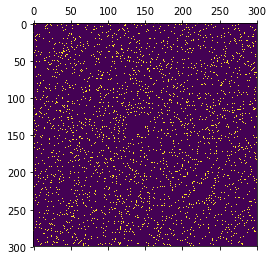

In [5]:
plt.matshow(matrix)

#### 2) create three communities

In [6]:
for row in range(100+overlap_nodes,num_nodes):
    for column in range(0,100):
        matrix[row,column]=0
        matrix[column,row]=0

In [7]:
for row in range(200+overlap_nodes,num_nodes):
    for column in range(0,200):
        matrix[row,column]=0
        matrix[column,row]=0

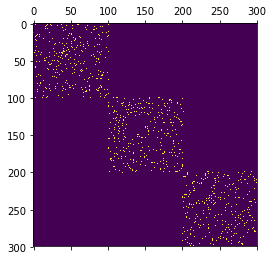

In [8]:
plt.matshow(matrix)

In [9]:
##### make sure every node connect to at least one node

In [10]:
for (node_1,row) in enumerate(matrix):
    if 1 not in row:
        randomm_index = np.random.randint(0,num_nodes)
        matrix[node_1,randomm_index]=1


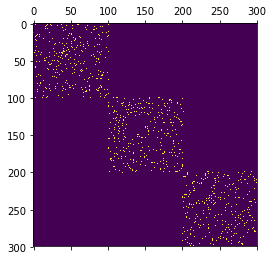

In [11]:
plt.matshow(matrix)

In [12]:
edge_list = []

In [13]:
for (node_1,row) in enumerate(matrix):
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            edge_list.append((node_1,node_2))


#### 3) visualize the network

In [14]:
G = nx.Graph()

In [15]:
G.add_edges_from(edge_list)

In [16]:
node_colors = []

In [17]:
for num in range(num_nodes):
    if num < 100:
        node_colors.append('orange')
    elif num >= 100 and num < 200:
        node_colors.append('plum')
    else:
        node_colors.append('lightcoral')

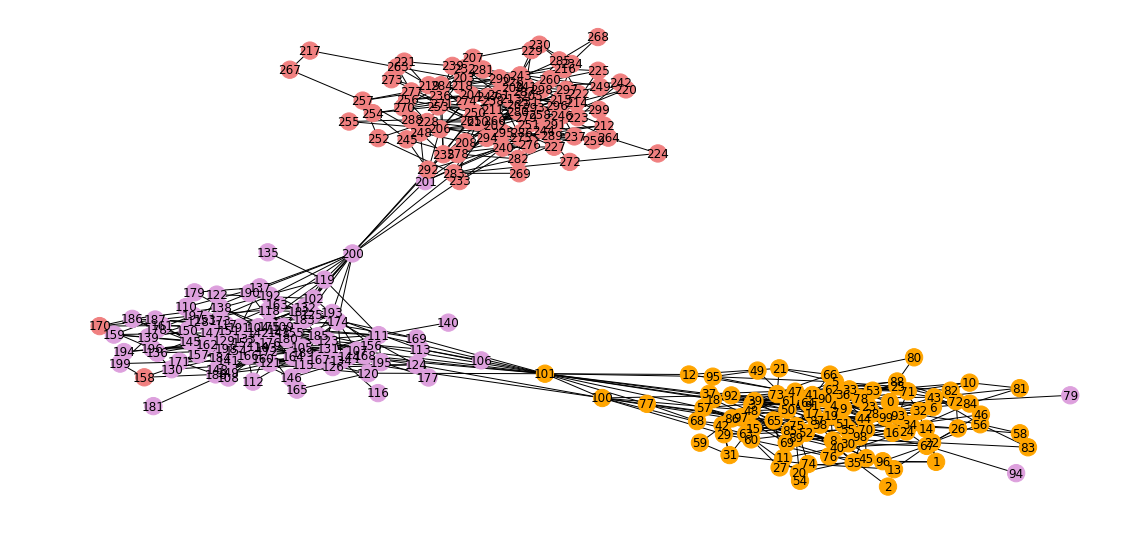

In [18]:
plt.figure(figsize=(15,7))
nx.draw(G,with_labels = True,node_color=node_colors)

### 2. Random Walk For Embedding: DeepWalk method

DeepWalk was proposed as the first network embedding method using techniques from the
representation learning (or deep learning) community. DeepWalk bridges the gap between network
embeddings and word embeddings by treating nodes as words and generating short random walks
as sentences. Then, neural language models such as Skip-gram can be applied on these random
walks to obtain network embedding.

In [19]:
edge_dict ={}

In [20]:
for (node_1,row) in enumerate(matrix):
    
    node_list =[]
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            
            node_list.append(node_2)
    
    edge_dict[node_1]=node_list
            
            

In [21]:
random_walk_matrix=[]

In [22]:
for _ in range(echo):
    for node in edge_dict:
        start_point = node
        walk_path = [start_point]

        ### select randomly for echo node
        for _ in range(walk_length-1):
            next_point = random.choice(edge_dict[start_point])  
            walk_path.append(next_point)
            start_point = next_point

        random_walk_matrix.append(walk_path)
        

In [23]:
random_walk_matrix=np.array(random_walk_matrix)

In [24]:
random_walk_matrix.shape

(3000, 8)

In [25]:
random_walk_matrix

array([[  0,  14,  22, ...,  67,  55,  24],
       [  1,  14,  78, ...,   3,  23,  61],
       [  2,  40,  11, ...,  65,  93,   6],
       ...,
       [297, 246, 297, ..., 214, 299, 210],
       [298, 251, 287, ..., 281, 287, 265],
       [299, 214, 213, ..., 264, 294, 238]])

### 3. Data Preparation For Embedding Training

In [26]:
root = random_walk_matrix[:,2]

In [27]:
root = root.reshape(-1,1)

In [28]:
roots = np.vstack([root for _ in range(walk_length-1)])

In [29]:
roots.shape

(21000, 1)

In [30]:
left_right = (walk_length-1)//2

In [31]:
i = list(range(walk_length))

In [32]:
i.remove(left_right)

In [33]:
random_walk_matrix[:,1].shape

(3000,)

In [34]:
target_nodes =[]

In [35]:
for num in i:
    temp_nodes = random_walk_matrix[:,num].reshape(-1,1)
    target_nodes.append(temp_nodes)

In [36]:
target_nodes = np.vstack(target_nodes)

In [37]:
target_nodes.shape

(21000, 1)

### 4. Skip-gram Training

In [38]:
batch_size = 64

In [39]:
def get_batch(X,Y,batch_size):
    batch_sum = 0
    data_size = X.shape[0]
    loop_size = data_size//batch_size
    for _ in range(loop_size):
        x = X[batch_sum:batch_sum+batch_size]
        y = Y[batch_sum:batch_sum+batch_size]
        
        batch_sum+=batch_size
        
        yield x,y

In [40]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
def n_gram(inputs, node_size = 500, n_dim=2, scope='skip-gram', reuse=tf.AUTO_REUSE):
    with tf.variable_scope(scope, reuse=reuse):
        with tf.device('/cpu:0'): ### assign tf using cpu, you may change it when you run the notebook in your env
            embeddings = tf.get_variable('embeddings', shape=[node_size, n_dim], initializer=tf.random_uniform_initializer)
        embed = tf.nn.embedding_lookup(embeddings, inputs)
        net = slim.fully_connected(embed,node_size, activation_fn=None, scope='classification')  
        return net,embeddings

In [42]:
input_ph = tf.placeholder(dtype=tf.int64, shape=[batch_size,1], name='input') 
label_ph = tf.placeholder(dtype=tf.int64, shape=[batch_size,1], name='label')

In [43]:
net,embeddings = n_gram(input_ph,num_nodes,n_dim =2)

In [44]:
### define the loss fuction
loss = tf.losses.sparse_softmax_cross_entropy(label_ph, net, scope='loss')

In [45]:
# opt = tf.train.MomentumOptimizer(1e-2, 0.9)
opt =tf.train.AdamOptimizer(1e-2)
train_op = opt.minimize(loss)

In [46]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [47]:
for e in range(100):
    train_losses = []
    
    for path, root in get_batch(roots,target_nodes,batch_size):
        _, curr_loss = sess.run([train_op, loss], feed_dict={input_ph: path, label_ph: root})
        train_losses.append(curr_loss)
        
    if (e + 1) % 20 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, np.mean(train_losses)))



Epoch: 20, Loss: 4.34566
Epoch: 40, Loss: 4.32988
Epoch: 60, Loss: 4.32249
Epoch: 80, Loss: 4.31781
Epoch: 100, Loss: 4.31469


In [49]:
embeddings_matrix = embeddings.eval()

In [50]:
x_coords = embeddings_matrix[:,0]
y_coords = embeddings_matrix[:,1]

(-7.536083347964617, 7.13324511783156, -4.094879470199291, 7.5064037660061755)

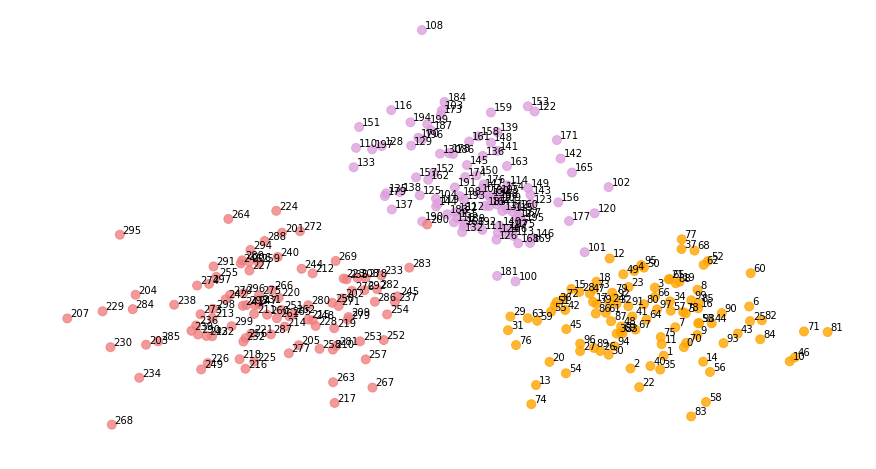

In [53]:
plt.figure(figsize=(15,8))
_ = plt.scatter(x_coords, y_coords, color=node_colors,alpha=0.8,s=80)
for i,node_id in enumerate(list(range(num_nodes))):
    x = x_coords[i]
    y = y_coords[i]
    _ =plt.text(x+0.05, y+0.05,node_id)
plt.axis('off')

### 5. Cluster to identify different groups

In [54]:
from sklearn.cluster import KMeans

In [55]:
random_state = 12

In [56]:
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(embeddings_matrix)

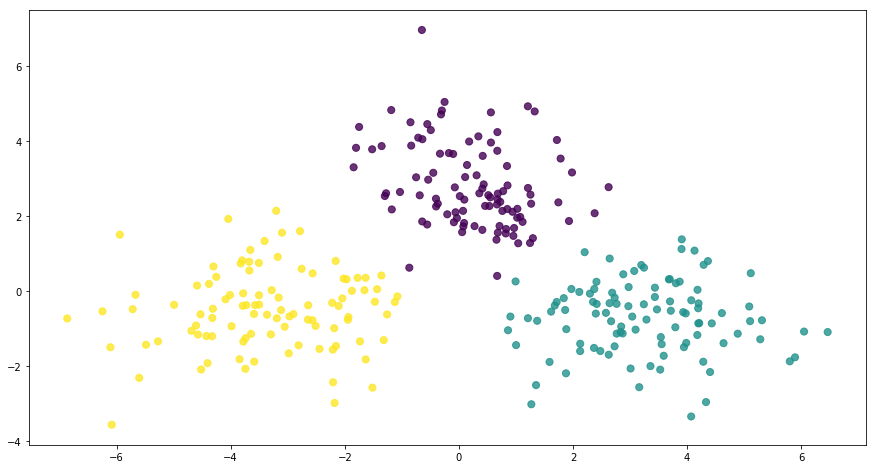

In [57]:
plt.figure(figsize=(15,8))
plt.scatter(embeddings_matrix[:,0],embeddings_matrix[:,1],c=y_pred,alpha=0.8,s =50)